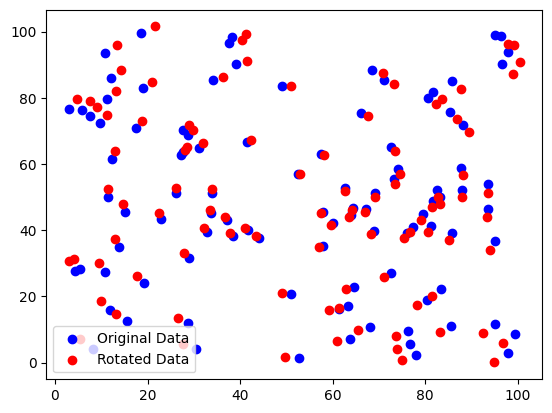

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import seaborn as sns
from scipy import stats
import math


class Survey:
    def __init__(self, data):
        """Initialize Survey with GeoDataFrame of X and Y coordinates."""
        self.data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.X, data.Y))
        self.X = self.data.geometry.x
        self.Y = self.data.geometry.y

    def plot_centers(self):
        """Plot the mean and median centers of the survey points."""
        mean_center = [self.X.mean(), self.Y.mean()]
        med_center = [self.X.median(), self.Y.median()]

        # Joint plot using seaborn
        sns.jointplot(x=self.X, y=self.Y, height=9, s=0.75)
        plt.scatter(*mean_center, color='red', marker='x', s=100, label='Mean Center')
        plt.scatter(*med_center, color='green', marker='o', s=100, label='Median Center')
        plt.legend()
        plt.show()


class SurveyProcessor:
    def __init__(self, mag=None, grav=None):
        """Initialize processor with optional magnetic and gravity data."""
        self.mag = Survey(mag) if isinstance(mag, pd.DataFrame) else None
        self.grav = Survey(grav) if isinstance(grav, pd.DataFrame) else None

    def process_survey(self, plot=False):
        """Process magnetic or gravity data, calculate a bounding box and rotate the data."""
        if self.mag is not None:
            rect_mag = self._bounding_box(self.mag)
            rotated_mag = self._rotate_data(self.mag, rect_mag, plot)
            return rotated_mag

        if self.grav is not None:
            rect_grav = self._bounding_box(self.grav)
            rotated_grav = self._rotate_data(self.grav, rect_grav, plot)
            return rotated_grav

    def _bounding_box(self, survey):
        """Get the minimum bounding rectangle for the survey points."""
        points = np.column_stack((survey.X, survey.Y))
        hull = ConvexHull(points)
        rect_points = points[hull.vertices]
        return Polygon(rect_points)

    def _rotate_data(self, survey, rect, plot):
        """Rotate survey data points around the bounding box's centroid."""
        centroid = rect.centroid
        angle = self._calculate_rotation_angle(rect)

        def rotate_point(point, origin, angle):
            """Rotate a point around an origin by a given angle."""
            ox, oy = origin
            px, py = point
            qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
            qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
            return qx, qy

        rotated_points = [rotate_point((x, y), (centroid.x, centroid.y), angle) for x, y in zip(survey.X, survey.Y)]
        rotated_df = pd.DataFrame(rotated_points, columns=["X_rotated", "Y_rotated"])

        if plot:
            plt.scatter(survey.X, survey.Y, color='blue', label="Original Data")
            plt.scatter(rotated_df.X_rotated, rotated_df.Y_rotated, color='red', label="Rotated Data")
            plt.legend()
            plt.show()

        return rotated_df

    def _calculate_rotation_angle(self, rect):
        """Calculate the rotation angle for the bounding box."""
        # Angle of rotation is calculated from the longest side of the rectangle
        x0, y0 = rect.exterior.coords[0]
        x1, y1 = rect.exterior.coords[1]
        angle = np.arctan2(y1 - y0, x1 - x0)
        return angle


# Example Usage
if __name__ == "__main__":
    # Sample survey data
    data_mag = pd.DataFrame({
        'X': np.random.uniform(0, 100, 100),
        'Y': np.random.uniform(0, 100, 100)
    })

    data_grav = pd.DataFrame({
        'X': np.random.uniform(0, 100, 100),
        'Y': np.random.uniform(0, 100, 100)
    })

    # Initialize the processor
    processor = SurveyProcessor(mag=data_mag, grav=data_grav)

    # Process the magnetic survey and plot the result
    processor.process_survey(plot=True)
